## Example of "indeterminancy"
In some cases, a sparsity inducing prior may lead to "indeterminancy", in the sense that we cannot determine which summary statistic is misspecified. Below is an example.

In [132]:
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rnpe.utils import get_manual_legend
from flowjax.flows import block_neural_autoregressive_flow
from flowjax.train_utils import train_flow
from flowjax.distributions import Normal
from numpyro.infer import MCMC, MixedHMC, HMC, init_to_value
from rnpe.denoise import spike_and_slab_denoiser
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def correlated_2d_gaussian_samples(key, n=10000, cor=0.8):
    x = random.normal(key, (n, 2))
    cov = jnp.array([[1, cor], [cor, 1]])
    return x @ jnp.linalg.cholesky(cov).T

key = random.PRNGKey(0)
key, x_key = random.split(key)
x = correlated_2d_gaussian_samples(x_key, cor=-0.9)
y = jnp.array([1.5, 1.5])


In [60]:


key, flow_key, train_key = random.split(key, 3)
base_dist = Normal(2)
x_flow = block_neural_autoregressive_flow(flow_key, base_dist)

x_flow, x_losses = train_flow(
    train_key,
    x_flow,
    x,
    learning_rate=0.01,
    max_epochs=50,
)


# Denoise observation with MCMC
init = init_to_value(
    values={"x": x[0], "misspecified": jnp.ones(len(y), int)}
)

kernel = MixedHMC(
    HMC(spike_and_slab_denoiser, trajectory_length=1, init_strategy=init, target_accept_prob=0.95,)
)

mcmc = MCMC(
    kernel,
    num_warmup=20000,
    num_samples=50000,
    progress_bar=False
)

key, mcmc_key = random.split(key)
model_kwargs = {"y_obs": y, "flow": x_flow}

mcmc.run(mcmc_key, **model_kwargs, )

  0%|          | 0/50 [00:00<?, ?it/s]/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
 62%|██████▏   | 31/50 [00:07<00:04,  3.89it/s, train=2.04, val=2]   


Max patience reached.


In [133]:
samples = mcmc.get_samples()
thin = 10
colors = ["#072D41", "#ECA918", "#359735"]

In [134]:
results = {}
results_array = jnp.zeros((2,2))
for idx1 in [0,1]:
    for idx2 in [0, 1]:
        res = ((samples["misspecified"][:, 0] == idx1) & (samples["misspecified"][:, 1] == idx2)).mean().item()
        results_array = results_array.at[idx2, idx1].set(res)

In [135]:
import seaborn as sns
sns.set_context("paper")
sns.set_style('whitegrid', {'font.family':'Times New Roman', 'font.serif':'serif', "font.size": 11})
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.axisbelow'] = True

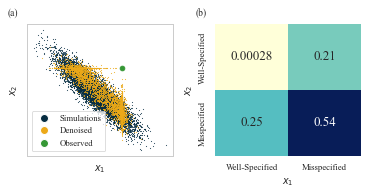

In [145]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(5.2, 2.8)

ax = axes[0]
ax.scatter(x[:, 0], x[:, 1], s=0.1, color=colors[0], rasterized=True)
ax.scatter(samples["x"][::thin, 0], samples["x"][::thin, 1], s=0.1, color=colors[1], rasterized=True)
ax.scatter(y[0], y[1], color=colors[2], rasterized=True)

labels = ["Simulations", "Denoised", "Observed"]
handles = get_manual_legend(labels, colors)
ax.legend(handles=handles, loc="lower left", )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax = axes[1]

df_cm = pd.DataFrame(results_array, ["Well-Specified", "Misspecified"], ["Well-Specified", "Misspecified"])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap="YlGnBu", cbar=False, ax=ax) # font size
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

import matplotlib.transforms as mtransforms
for label, ax in zip(["(a)", "(b)"], axes):
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='medium', va='bottom')
fig.tight_layout()

plt.savefig("../../results/plots/indeterminancy_example.pdf", dpi=400)
plt.show()
